# Problem Statement

The task is to predict the total number of rental bikes on a particular day by considering various features given by the **Bike Sharing Demand Dataset**. 

# Data Preprocessing and Baseline

## Data Loading and Feature Engineering

In [1]:
import numpy as np
import pandas as pd

In [2]:
dataset = pd.read_csv('./dataset/hour.csv')
print(f"{dataset.shape}")

(17379, 17)


In [3]:
dataset.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [4]:
dataset.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)
print(f"{dataset.shape}")

(17379, 13)


In [5]:
dataset.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [6]:
one_hot_encoding_cols = [0, 1, 2, 7]
numeric_columns = [col_no for col_no, col in enumerate(dataset.columns) if col_no not in one_hot_encoding_cols and col != 'cnt']

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Train/Test Split

In [8]:
X = dataset.drop(columns=['cnt'])
y = dataset['cnt']

print(f"Shape of features: {X.shape}")
print(f"Shape of labels: {y.shape}")

Shape of features: (17379, 12)
Shape of labels: (17379,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Baseline Model (Single Regressor)

In [10]:
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()
lin_reg = LinearRegression()
dec_tree = DecisionTreeRegressor(max_depth=6)

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', one_hot_encoder, one_hot_encoding_cols),
        ('scaler', scaler, numeric_columns)
    ],
    remainder='passthrough'
)

In [12]:
lin_reg_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', lin_reg)
    ]
)

In [13]:
dt_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', dec_tree)
    ]
)

In [14]:
from sklearn.metrics import mean_squared_error

lin_reg_pipeline.fit(X_train, y_train)
dt_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...), ('scaler', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
y_pred_lin_reg = lin_reg_pipeline.predict(X_test)
y_pred_dt = dt_pipeline.predict(X_test)

rmse_lin_reg = mean_squared_error(y_test, y_pred_lin_reg) ** 0.5
rmse_dt = mean_squared_error(y_test, y_pred_dt) ** 0.5

print(f"The RMSE for Linear Regression is: {rmse_lin_reg:.4f}")
print(f"The RMSE for Decision Tree is: {rmse_dt:.4f}")

The RMSE for Linear Regression is: 137.0278
The RMSE for Decision Tree is: 99.3500


We can see that the **Decision Tree with Max Depth 6** is performing better and it will be used as the baseline model.

In [16]:
baseline_pipeline = dt_pipeline

# Ensemble Techniques for Bias and Variance Reduction

## Bagging (Variance Reduction)

In [17]:
from sklearn.ensemble import BaggingRegressor

In [18]:
number_of_estimators = [1, 50, 100, 200, 500, 1000]
rmse_bagging = dict()

for n in number_of_estimators:
    bagging_model =  BaggingRegressor(
        estimator=dt_pipeline,
        n_estimators=n,
        max_samples=1.0,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

    bagging_model.fit(X_train, y_train)

    y_pred = bagging_model.predict(X_test)

    rmse_bagging[n] = mean_squared_error(y_test, y_pred) ** 0.5

In [42]:
print(f"The best bagging regressor has a score of: {min(rmse_bagging.values()):.4f}")

The best bagging regressor has a score of: 95.9448


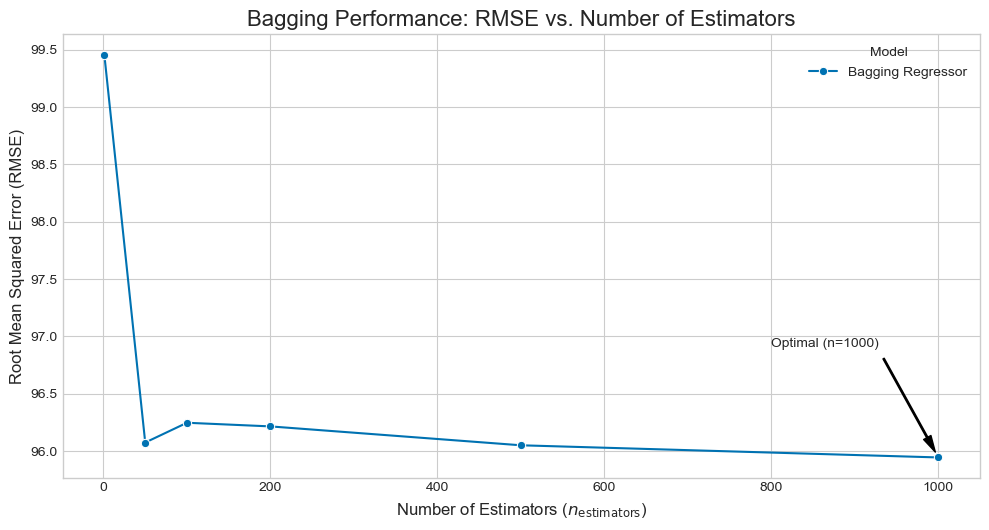

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the dictionary to a DataFrame
rmse_df = pd.DataFrame(
    list(rmse_bagging.items()), 
    columns=['n_estimators', 'RMSE']
)

plt.style.use('seaborn-v0_8-whitegrid') # Inclusive color palette
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the line chart
sns.lineplot(
    x='n_estimators', 
    y='RMSE', 
    data=rmse_df, 
    marker='o', # Relevant marker
    color='#0072B2', # Colorblind-friendly blue
    ax=ax
)

# Annotate the minimum RMSE point
min_rmse = rmse_df['RMSE'].min()
min_n = rmse_df.loc[rmse_df['RMSE'].idxmin(), 'n_estimators']
ax.annotate(
    f'Optimal (n={min_n})',
    xy=(min_n, min_rmse),
    xytext=(min_n * 0.8, min_rmse * 1.01), # Adjust text position
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
    fontsize=10
)

# Set the title and labels
ax.set_title('Bagging Performance: RMSE vs. Number of Estimators', fontsize=16)
ax.set_xlabel('Number of Estimators ($n_{\\text{estimators}}$)', fontsize=12)
ax.set_ylabel('Root Mean Squared Error (RMSE)', fontsize=12)

# Legend
ax.legend(['Bagging Regressor'], title='Model', loc='upper right')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

Clearly bagging reduces the variance of the model. We can say this because for the sample bias (same model), we are able to reduce the error. However, according to the **bias-variance tradeoff**, any change in error must be attributed to either the bias or the variance. Since the bias is fixed, the only conclusion is that the variance has reduced.

However, we can see that the reduction in error is not a lot even for 1000 estimators, which suggests that **most of the error is from the model bias**.

## Boosting (Bias Reduction)

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
boosting_model = GradientBoostingRegressor(
    loss='squared_error',
    random_state=42
)

boosting_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', boosting_model)
    ]
)

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
param_grid = {
    'model__learning_rate': [0.05, 0.1, 0.2, 0.5],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 25, 50]
}

In [24]:
boosting_search = GridSearchCV(
    estimator=boosting_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    refit=True,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)

In [25]:
boosting_search.fit(X_train, y_train)

print(f"Finished Grid Search CV!")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Finished Grid Search CV!


In [29]:
boosting_results_df = pd.DataFrame(boosting_search.cv_results_)

# 'params' contains the dictionary of parameters tested
# 'mean_test_score' is the average score from cross-validation
# 'std_test_score' is the standard deviation of the test scores
# 'rank_test_score' is the rank of the parameter combination (1 being the best)

selected_columns = [
    'params', 
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
]

# Create the final results DataFrame
final_results = boosting_results_df[selected_columns].sort_values(by='rank_test_score').reset_index(drop=True)

final_results['mean_test_score'] = (-final_results['mean_test_score']) ** 0.5

# Display the top results
final_results.head(10)

,params,mean_test_score,std_test_score,rank_test_score
0,"{'model__learning_rate': 0.05, 'model__max_dep...",44.173672,40.907379,1
1,"{'model__learning_rate': 0.1, 'model__max_dept...",44.373688,64.815634,2
2,"{'model__learning_rate': 0.1, 'model__max_dept...",44.465030,59.095564,3
3,"{'model__learning_rate': 0.2, 'model__max_dept...",44.653576,107.548871,4
4,"{'model__learning_rate': 0.05, 'model__max_dep...",44.699258,51.460256,5
5,"{'model__learning_rate': 0.1, 'model__max_dept...",44.816308,75.390636,6
6,"{'model__learning_rate': 0.2, 'model__max_dept...",44.963339,80.055606,7
7,"{'model__learning_rate': 0.2, 'model__max_dept...",45.066552,76.393099,8
8,"{'model__learning_rate': 0.2, 'model__max_dept...",45.125763,74.677769,9
9,"{'model__learning_rate': 0.1, 'model__max_dept...",45.772973,62.543366,10


In [31]:
y_pred = boosting_search.best_estimator_.predict(X_test)

rmse_boosting = mean_squared_error(y_test, y_pred) ** 0.5

print(f"The RMSE for the best Boosting Model is: {rmse_boosting:.4f}")

The RMSE for the best Boosting Model is: 39.2617


Notice how the score for the best boosting model is much better than the bagged or the baseline model. This verifies our hypothesis earlier that most of the model error is actually from bias. By boosting, we're reducing the bias by a lot. The best fitted model has the following parameters.

In [33]:
boosting_search.best_estimator_

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...), ('scaler', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Stacking for Optimal Performance

## Stacking Implementation

**Stacking** (short for **Stacked Generalization**) is an advanced ensemble technique used to improve predictive accuracy by combining the strengths of **diverse base learners**. Instead of just averaging predictions (like Bagging) or sequentially correcting errors (like Boosting), Stacking uses a separate model, the **Meta-Learner**, to figure out the optimal way to combine the outputs of the base models.

### Principle of Stacking

The principle of Stacking is based on the idea that different types of models (e.g., a linear model, a tree model, and a distance-based model) will make different kinds of errors. By combining them, we leverage their unique strengths to minimize the overall error.

#### 1. Base Learners (Level 0)

* **Diversity is Key:** We start by selecting several **diverse** models (the Base Learners or Level 0 models), such as Logistic Regression, k-Nearest Neighbors, and a Random Forest. These models are chosen because they operate on fundamentally different principles.
* **Prediction Generation:** Each Base Learner is trained on the full training dataset and generates its own set of predictions (or probabilities).

#### 2. Meta-Learner (Level 1)

* The Meta-Learner is the final model in the stack. Its job is to take the **predictions** from the Base Learners as its **new input features** and learn how to combine them optimally to produce the final, best prediction.

### How the Meta-Learner Learns to Combine Predictions

The Meta-Learner learns the optimal combination weights through a standard supervised learning process, which requires generating a clean, unbiased training set for itself.

#### Generating Training Data (Cross-Validation / Hold-Out)

The most critical step in Stacking is preventing **data leakage**, which occurs if the Meta-Learner trains on the same predictions that the Base Learners made on the training data. This would lead to massive overfitting.

To prevent this, a cross-validation technique is typically used:

* **K-Fold Split:** The training data is split into $K$ folds.
* **Prediction Generation:** For each fold, the Base Learner is trained on the $K-1$ other folds and then used to predict the targets for the held-out $K$-th fold. This is repeated until every training sample has an **unbiased prediction** from the Base Learner.
* **New Feature Matrix:** The output of this process is a new training matrix ($\mathbf{Z}$) for the Meta-Learner.

#### Optimal Combination (Model Training)

* The Meta-Learner (often a simple model like Logistic Regression, which is trained on $\mathbf{Z}$ and the original target $\mathbf{y}$) learns the optimal weights (coefficients) to assign to each Base Learner's output.
* If Base Learner A is very good at identifying Class 1 but poor at Class 2, the Meta-Learner will learn to give a high weight to A's predictions when the input $\mathbf{Z}$ suggests Class 1, and a low weight otherwise.

By training the Meta-Learner, we let the model itself decide which Base Learner is reliable under which circumstances, leading to an overall robust and typically high-performing ensemble. 

In [36]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

knn_regressor = KNeighborsRegressor(n_neighbors=10)
bagging_regressor =  BaggingRegressor(
    estimator=dt_pipeline,
    n_estimators=1000,
    max_samples=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
gradient_boosting_regressor = boosting_search.best_estimator_

stacking_regressor = StackingRegressor(
    estimators=[
        ('knn', knn_regressor),
        ('bagging', bagging_regressor),
        ('boosting', boosting_model)
    ],
    final_estimator=Ridge(),
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [37]:
stacking_regressor.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.3s finished


,estimators,"[('knn', ...), ('bagging', ...), ...]"
,final_estimator,Ridge()
,cv,3
,n_jobs,-1
,passthrough,False
,verbose,1
,n_neighbors,10
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2


In [39]:
y_pred = stacking_regressor.predict(X_test)

rmse_stacking = mean_squared_error(y_test, y_pred) ** 0.5
print(f"The RMSE for Stacking Regressor is: {rmse_stacking:.4f}")

The RMSE for Stacking Regressor is: 51.8268


# Final Analysis

## Comparative Table

| Model | RMSE |
| --- | --- |
| Linear Regression | 137.0278 |
| Decision Tree | 99.3500 |
| Bagging | 95.9448 |
| Boosting | 39.3617 |
| Stacking | 51.8268 |

From the above table, we can see that the **boosting model** seems to perform the best.

## Conclusion

/tmp/ipykernel_33677/1050885228.py:24: UserWarning: 
The palette list has fewer values (5) than needed (869) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


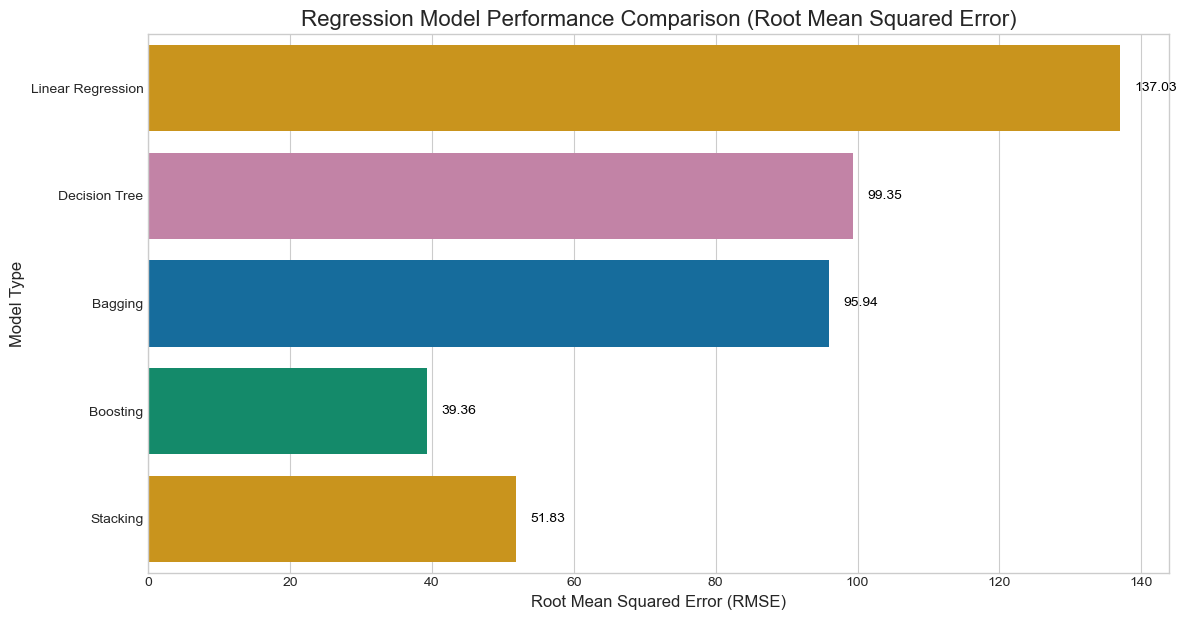

In [45]:
model_data = {
    'Model': ['Linear Regression', 'Decision Tree', 'Bagging', 'Boosting', 'Stacking'],
    'RMSE': [137.0278, 99.3500, 95.9448, 39.3617, 51.8268]
}
rmse_df = pd.DataFrame(model_data)

# Define a colorblind-friendly palette
# We will use a color gradient to visually emphasize performance differences.
colors = sns.color_palette("viridis", n_colors=len(rmse_df))
# The lowest RMSE (Boosting) will get a unique, high-contrast color.
colors_map = {
    'Boosting': '#D55E00', # High contrast orange for the winner
    'Bagging': '#009E73',
    'Decision Tree': '#0072B2',
    'Stacking': '#CC79A7',
    'Linear Regression': '#E69F00'
}
color_list = [colors_map[model] for model in rmse_df['Model']]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Create the bar chart
sns.barplot(
    x='RMSE',
    y='Model',
    data=rmse_df,
    palette=color_list,
    ax=ax,
    hue=y,
    legend=False
)

# Annotate the bars with the exact RMSE values
for i, (rmse, model) in enumerate(zip(rmse_df['RMSE'], rmse_df['Model'])):
    ax.text(rmse + 2, i, f'{rmse:.2f}', va='center', fontsize=10, color='black')

# Set the title and labels
ax.set_title('Regression Model Performance Comparison (Root Mean Squared Error)', fontsize=16)
ax.set_xlabel('Root Mean Squared Error (RMSE)', fontsize=12)
ax.set_ylabel('Model Type', fontsize=12)

# Ensure the zero-point is included
ax.set_xlim(0, max(rmse_df['RMSE']) * 1.05)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

From the above plot, we can clearly see that the **boosting model performs the best with an RMSE of 39.36**.

### Bias-Variance Trade-Off and Model Strategy

The performance of an ensemble model is defined by how it attacks the two types of model error:

| Model Strategy | Primary Error Reduction | Mechanism |
| :--- | :--- | :--- |
| **Decision Tree (Baseline)** | Lowers **Bias** | Highly flexible; can learn complex, non-linear relationships. *Primary downside is high variance.* |
| **Bagging (RMSE 95.9448)** | Lowers **Variance** | Trains many independent, high-variance models (trees) and **averages** their predictions. Errors from variance cancel out. |
| **Boosting (RMSE 39.3617)** | Lowers **Bias** | Sequentially trains models to focus on and correct the **errors (bias)** of the previous model, achieving superior fit to the data. |
| **Stacking (RMSE 51.8268)** | Lowers **Bias** & **Variance** | Uses a **Meta-Learner** to learn the optimal way to blend predictions, correcting for the systematic weaknesses (bias) of the Base Learners. |

### Conclusion on Performance

* **Decision Tree vs. Bagging:** The drop from 99.3500 (single tree) to 95.9448 (Bagging) is a direct demonstration of **variance reduction**. Bagging stabilizes the volatile Decision Tree, leading to a more reliable, albeit still high, error score.
* **Boosting's Dominance:** Boosting achieved the lowest error (39.3617) because it aggressively lowered **bias**, forcing the ensemble to achieve the best possible fit by fixing sequential errors.

### Aggressive Bias Reduction

The fundamental difference between Boosting and Bagging/Stacking is its focus on error correction:

* **Sequential Learning:** Boosting trains models sequentially. Each new model ($M_t$) is built specifically to correct the mistakes (the **residuals** or errors) made by the previous ensemble ($M_{t-1}$).
* **Focus on Hard Samples:** By focusing only on the observations that were difficult for the previous models to predict correctly, Boosting drives the overall **bias** of the entire ensemble down with every single iteration.
* **Optimal Performance:** This iterative, focused correction process allows the Boosting ensemble to achieve a much better fit to the complex underlying data pattern than methods like Bagging, which only average errors.

### Low Variance in Base Estimators

While Boosting's primary mechanism is bias reduction, it also manages variance by using **weak learners** (typically shallow decision trees, e.g., `max_depth=3` to $5$).

* **Controlled Complexity:** By keeping the individual base trees shallow (low-variance), the boosting algorithm prevents any single tree from overfitting the data noise.
* **Accumulated Power:** The final complex, powerful model is created by accumulating the contributions of hundreds of these simple, stable trees, resulting in low overall variance.

### Difference from Stacking

While Stacking also reduces bias and variance, Boosting achieves better results in this scenario because:

* **Stacking is a "Passive" Blender:** Stacking trains models independently and then passively learns to blend their outputs. It doesn't actively change the behavior of the base models.
* **Boosting is an "Active" Corrector:** Boosting actively forces every subsequent model to learn what the previous models got wrong. This active, directed focus on the error signal ($y - \hat{y}$) provides a much more optimized and often lower error score than any form of passive aggregation.